<center> <font size="6"> <div class="alert alert-block alert-success"> <strong> A2Z Insurance Customer Segmentation Project 
</strong> </div> </font> </center>

<center> <font size="4"> <div class="alert alert-block alert-success"> <strong> Hierarchical Clustering 
</strong> </div> </font> </center>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from math import ceil
from matplotlib.lines import Line2D
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar, colors as mpl_colors, __version__ as mplver
plt.rcParams['figure.dpi'] = 50

from scipy.cluster.hierarchy import dendrogram

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

## Import Data

In [2]:
#import pre-prec dataset
df_ohc = pd.read_csv('preproc_data.csv')

df_ohc = df_ohc.rename(columns={"x0_b'2 - High School'":'High School', 
                              "x0_b'3 - BSc/MSc'":'BSc/MSc', 
                              "x0_b'4 - PhD'":'PhD', 
                              'x1_Diamond':'Diamond', 
                              'x1_Gold':'Gold', 
                              'x1_Silver':'Silver',
                              })

In [3]:
#define perspectives
demo = df_ohc[['High School', 'BSc/MSc', 'PhD', 'MonthSal', 'Children']].copy()

cust_val = df_ohc[['CustMonVal', 'Client Tenure', 'Total Premium']].copy()

## Hierarchical Clustering

### Perspective 1: Customer Value

* First attempt at HC

In [4]:
from sklearn.cluster import AgglomerativeClustering

hclust = AgglomerativeClustering(linkage='ward',
                                 affinity='euclidean',
                                 n_clusters=5)
hc_labels1 = hclust.fit_predict(cust_val)
hc_labels1

array([3, 1, 2, ..., 4, 0, 2], dtype=int64)

In [5]:
df_concat = pd.concat(
    (cust_val, pd.Series(hc_labels1, name='labels_hc1', index=cust_val.index)),
    axis=1)
df_concat.groupby('labels_hc1').mean()

,CustMonVal,Client Tenure,Total Premium
labels_hc1,,,
0,0.890270,0.797517,0.156710
1,0.897800,0.182781,0.333565
2,0.888327,0.374732,0.154520
3,0.888537,0.561769,0.136375
4,0.888150,0.183390,0.126528


* Select HC method

In [6]:
# Computing SST
X = cust_val.values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels1):
    X_k = X[hc_labels1 == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels1):
    X_k = X[hc_labels1 == i]
    ssb_iter.append(X_k.shape[0] *
                    np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula: SST = SWW + SSB
# np.round(sst) == np.round((ssw + ssb))

In [7]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss

    sst = get_ss(df)

    r2 = []

    for i in range(min_nclus, max_nclus + 1):
        cluster = AgglomerativeClustering(n_clusters=i,
                                          affinity=dist,
                                          linkage=link_method)
        hclabels = cluster.fit_predict(df)
        df_concat = pd.concat(
            (df, pd.Series(hclabels, name='labels', index=cust_val.index)),
            axis=1)
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)
        ssb = sst - np.sum(ssw_labels)
        r2.append(ssb / sst)

    return np.array(r2)

In [8]:
hc_methods = ["ward", "complete", "average", "single"]

max_nclus = 5
r2_hc_methods = np.vstack([
    get_r2_hc(df=cust_val, link_method=link, max_nclus=max_nclus)
    for link in hc_methods
]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods,
                             index=range(1, max_nclus + 1),
                             columns=hc_methods)

sns.set()

In [9]:
r2_hc_methods

,ward,complete,average,single
1,0.000000,0.000000,0.000000,0.000000
2,0.569198,0.626366,0.007660,0.001133
3,0.744657,0.629571,0.010504,0.002887
4,0.795793,0.682336,0.010807,0.003247
5,0.835513,0.757218,0.611619,0.003443


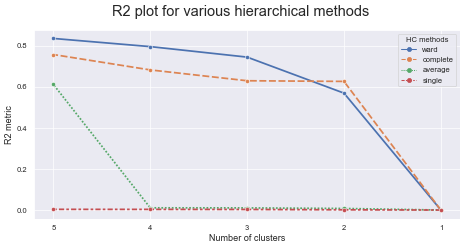

In [10]:
fig = plt.figure(figsize=(11, 5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"] * 4)
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

* Select number of clusters

In [11]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage,
                                 affinity=distance,
                                 distance_threshold=0,
                                 n_clusters=None)
hclust.fit_predict(cust_val)

array([6896, 5260, 5491, ...,    1,    2,    0], dtype=int64)

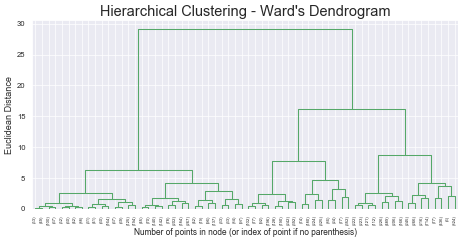

In [12]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([hclust.children_, hclust.distances_,
                                  counts]).astype(float)

sns.set()
fig = plt.figure(figsize=(11, 5))
y_threshold = 60
#plt.axhline(y=15)
#plt.axhline(y=12.5)
dendrogram(linkage_matrix,
           truncate_mode='level',
           p=5,
           color_threshold=y_threshold,
           above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram',
          fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

* Final HC 

In [13]:
linkage = 'ward'
distance = 'euclidean'
clusters = 2

In [14]:
hc1 = AgglomerativeClustering(linkage=linkage,
                              affinity=distance,
                              n_clusters=clusters)
hc1_labels = hc1.fit_predict(cust_val)

In [15]:
df_concat1 = pd.concat(
    (cust_val, pd.Series(hc1_labels, name='labels_hc1', index=cust_val.index)),
    axis=1)
df_concat1.groupby('labels_hc1').describe().T

labels_hc1                     0            1
CustMonVal    count  7310.000000  2931.000000
              mean      0.890083     0.890270
              std       0.023699     0.014108
              min       0.000000     0.859676
              25%       0.876940     0.876952
              50%       0.888470     0.889220
              75%       0.901227     0.901428
              max       1.000000     0.961327
Client Tenure count  7310.000000  2931.000000
              mean      0.347510     0.797517
              std       0.161078     0.102753
              min       0.000000     0.576923
              25%       0.230769     0.730769
              50%       0.346154     0.807692
              75%       0.461538     0.884615
              max       0.692308     1.000000
Total Premium count  7310.000000  2931.000000
              mean      0.177575     0.156710
              std       0.103868     0.076686
              min       0.006439     0.000000
              25%       0.108390     0.104485
              50%       0.146604     0.137161
              75%       0.213603     0.189339
              max       1.000000     0.546469

In [16]:
df_ohc['cust_val'] = df_concat1['labels_hc1']

### Perspective 2: Customer Demography

* First attempt at HC

In [17]:
from sklearn.cluster import AgglomerativeClustering

hclust = AgglomerativeClustering(linkage='ward',
                                 affinity='euclidean',
                                 n_clusters=5)
hc_labels2 = hclust.fit_predict(demo)
hc_labels2

array([4, 4, 0, ..., 1, 2, 2], dtype=int64)

In [18]:
df_concat = pd.concat(
    (demo, pd.Series(hc_labels2, name='labels_hc2', index=demo.index)), axis=1)
df_concat.groupby('labels_hc2').mean()

,High School,BSc/MSc,PhD,MonthSal,Children
labels_hc2,,,,,
0,0.63995,0.0,0.130244,0.584833,0.000626
1,0.00000,1.0,0.000000,0.422108,0.999824
2,0.00000,0.0,0.358187,0.348781,0.999415
3,0.00000,1.0,0.000000,0.646756,0.000000
4,1.00000,0.0,0.000000,0.399152,0.999757


* Select HC method

In [19]:
X = demo.values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

ssw_iter = []
for i in np.unique(hc_labels2):
    X_k = X[hc_labels2 == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

ssb_iter = []
for i in np.unique(hc_labels2):
    X_k = X[hc_labels2 == i]
    ssb_iter.append(X_k.shape[0] *
                    np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula: SST = SWW + SSB
# np.round(sst) == np.round((ssw + ssb))

In [20]:
hc_methods = ["ward", "complete", "average", "single"]

max_nclus = 10
r2_hc_methods = np.vstack([
    get_r2_hc(df=demo, link_method=link, max_nclus=max_nclus)
    for link in hc_methods
]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods,
                             index=range(1, max_nclus + 1),
                             columns=hc_methods)

sns.set()

In [21]:
r2_hc_methods

,ward,complete,average,single
1,0.000000,0.000000,0.000000,0.000000
2,0.452561,0.418202,0.111961,0.111961
3,0.597889,0.569280,0.569280,0.569280
4,0.726827,0.695585,0.695585,0.684289
5,0.850274,0.729613,0.729613,0.813227
6,0.902027,0.858551,0.858551,0.906591
7,0.941587,0.939570,0.877582,0.925623
8,0.958602,0.958602,0.958602,0.958602
9,0.965704,0.963021,0.961754,0.958622
10,0.972155,0.966504,0.965936,0.958651


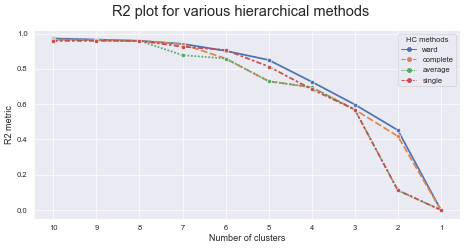

In [22]:
fig = plt.figure(figsize=(11, 5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"] * 4)
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

* Select number of clusters

In [23]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage,
                                 affinity=distance,
                                 distance_threshold=0,
                                 n_clusters=None)
hclust.fit_predict(demo)

array([10240,  8279,  6231, ...,     4,     1,     0], dtype=int64)

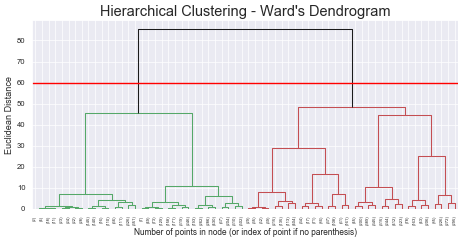

In [24]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([hclust.children_, hclust.distances_,
                                  counts]).astype(float)

sns.set()
fig = plt.figure(figsize=(11, 5))
dendrogram(linkage_matrix,
           truncate_mode='level',
           p=5,
           color_threshold=y_threshold,
           above_threshold_color='k')
plt.axhline(y=60, c='red', lw=2)
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram',
          fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

* Final HC 

In [25]:
linkage = 'ward'
distance = 'euclidean'
clusters = 2

In [26]:
hc2 = AgglomerativeClustering(linkage=linkage,
                              affinity=distance,
                              n_clusters=clusters)
hc2_labels = hc2.fit_predict(demo)

In [27]:
df_concat2 = pd.concat(
    (demo, pd.Series(hc2_labels, name='labels_hc2', index=demo.index)), axis=1)
df_concat2.groupby('labels_hc2').describe().T.head(50)

labels_hc2                   0            1
High School count  5438.000000  4803.000000
            mean      0.642700     0.000000
            std       0.479248     0.000000
            min       0.000000     0.000000
            25%       0.000000     0.000000
            50%       1.000000     0.000000
            75%       1.000000     0.000000
            max       1.000000     0.000000
BSc/MSc     count  5438.000000  4803.000000
            mean      0.000000     1.000000
            std       0.000000     0.000000
            min       0.000000     1.000000
            25%       0.000000     1.000000
            50%       0.000000     1.000000
            75%       0.000000     1.000000
            max       0.000000     1.000000
PhD         count  5438.000000  4803.000000
            mean      0.128356     0.000000
            std       0.334517     0.000000
            min       0.000000     0.000000
            25%       0.000000     0.000000
            50%       0.000000     0.000000
            75%       0.000000     0.000000
            max       1.000000     0.000000
MonthSal    count  5438.000000  4803.000000
            mean      0.441010     0.487450
            std       0.219064     0.194679
            min       0.000000     0.006826
            25%       0.256826     0.331378
            50%       0.438460     0.486775
            75%       0.618121     0.641212
            max       1.000000     0.994454
Children    count  5438.000000  4803.000000
            mean      0.706252     0.709015
            std       0.455164     0.454154
            min       0.000000     0.000000
            25%       0.000000     0.000000
            50%       1.000000     1.000000
            75%       1.000000     1.000000
            max       1.000000     1.000000

In [28]:
df_ohc['demo'] = df_concat2['labels_hc2']

## Evaluation

### Perspective 1: Customer Value

* Silhouette Score

In [29]:
def silhouette(X, algorithm):
    range_n_clusters = [2]
    silhouette_scores = []

    for n_clusters in range_n_clusters:
        clusterer = algorithm(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

    return silhouette_scores

In [30]:
custval_hc = df_concat1.copy()
custval_hc['labels_hc1'] = hc1.labels_

cluster0 = custval_hc[custval_hc.labels_hc1 == 0]
cluster1 = custval_hc[custval_hc.labels_hc1 == 1]
s_hc1 = custval_hc.iloc[:, 1:-1].values

hc_silhouette = silhouette(s_hc1, AgglomerativeClustering)

For n_clusters = 2 The average silhouette_score is : 0.4322498885050029


* R^2

In [31]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss

In [32]:
sst = get_ss(cust_val)  
ssw_labels = df_concat1.groupby(by='labels_hc1').apply(
    get_ss)  
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.5692


### Perspective 2: Customer Demography

* Silhouette Score

In [33]:
def silhouette(X, algorithm):
    range_n_clusters = [5]
    silhouette_scores = []

    for n_clusters in range_n_clusters:
        clusterer = algorithm(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

    return silhouette_scores

In [34]:
demo_hc = df_concat2.copy()
demo_hc['labels_hc2'] = hc2.labels_

cluster0 = demo_hc[demo_hc.labels_hc2 == 0]
cluster1 = demo_hc[demo_hc.labels_hc2 == 1]
cluster2 = demo_hc[demo_hc.labels_hc2 == 2]
cluster3 = demo_hc[demo_hc.labels_hc2 == 3]
cluster4 = demo_hc[demo_hc.labels_hc2 == 4]

s_hc2 = demo_hc.iloc[:, 1:-1].values

hc_silhouette = silhouette(s_hc2, AgglomerativeClustering)

For n_clusters = 5 The average silhouette_score is : 0.7780757157845202


* R^2

In [35]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss

In [36]:
sst = get_ss(demo) 
ssw_labels = df_concat2.groupby(by='labels_hc2').apply(
    get_ss)  
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.4526
